Last updated: January 1, 2025

It is recommended to open this in Google Colab because certain portions of the code requires a GPU. Holding one model in memory should work on the free tier of Colab. Thus, this notebook is designed so that the seed is reset every time it gets to a section where the model is being built and predictions are being called in case you ever want to revisit the notebook after walking away. It should be possible to run this notebook from top to bottom without the free tier expiring.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_006_AES/AES_2_model_no_custom.ipynb)

Continuing where I left off in the previous notebook (data exploration), I am going to be building a model to examine whether a large language model (LLM) will systematically produce different essay scores for English language learners (ELLs) as compared to a population of general English writers when the training is done on a general population. As such, I am not judging the accuracy of the ELL predictions but the distribution, and therefore do not need to ensure that the labels are the same across the two datasets.

I decided to use a BERT-base-cased model in PyTorch and fine-tuned it for automatic essay scoring (AES). As this is my first time using PyTorch and I'm learning how to use it, I copied the code from a [guide](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) and updated it to suit my project.

# Libraries, Datasets, and Custom Functions

In [1]:
### only used for Google Colab
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


I am operating out of the "data" folder in my Google Drive.

In [2]:
%cd data

/content/gdrive/MyDrive/data


In [3]:
# libraries
import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle

import time
import datetime

import transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import TFAutoModel, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind

I am using the final datasets from the data exploration section of the  notebook. This means I will be splitting up the `asap_train` into training, validation, and test sets. 10 percent of the data will be reserved for the test set. Afterwards, when the model is being built, 20% of the remaining portion will be used for validation.

In [4]:
asap_train = pd.read_csv('training_set_rel3.tsv', sep='\t', header=0, encoding="ISO-8859-1")

ell_train = pd.read_csv("ELLIPSE_Final_github_train.csv")
ell_test = pd.read_csv("ELLIPSE_Final_github_test.csv")

ell_train_fin = ell_train[ell_train['grade']<=10]
ell_test_fin = ell_test[ell_test['grade']<=10]

In [5]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
indices = list(range(asap_train.shape[0]))
random.shuffle(indices)
cutoff = 0.9*asap_train.shape[0]
cutoff = int(round(cutoff,0))

train_indices = indices[0:cutoff]
test_indices = indices[cutoff:]

x_train = asap_train.iloc[train_indices,]["essay"]
y_train1 = asap_train.iloc[train_indices,]["domain1_score"]

x_test = asap_train.iloc[test_indices,]["essay"]
y_test1 = asap_train.iloc[test_indices,]["domain1_score"]

In [7]:
train_indices

[12670,
 9153,
 3274,
 1217,
 4477,
 4185,
 10613,
 8094,
 3424,
 7108,
 8081,
 4386,
 10493,
 3141,
 9703,
 9566,
 7205,
 10812,
 11106,
 232,
 12455,
 4236,
 12560,
 1477,
 4926,
 4196,
 8538,
 2160,
 7710,
 5947,
 2388,
 2323,
 4568,
 3254,
 6183,
 9185,
 10312,
 12595,
 4241,
 421,
 494,
 3617,
 10435,
 11746,
 2115,
 6178,
 358,
 2462,
 10715,
 4395,
 7563,
 9134,
 10342,
 9831,
 1661,
 6737,
 963,
 11235,
 2825,
 4542,
 7384,
 10547,
 810,
 9341,
 1069,
 4013,
 2574,
 10222,
 12956,
 11062,
 1210,
 11888,
 5445,
 10396,
 2178,
 12879,
 6565,
 6536,
 6070,
 7017,
 7907,
 11333,
 6713,
 4480,
 11146,
 9742,
 6220,
 9220,
 8573,
 5298,
 11267,
 875,
 11861,
 925,
 8373,
 5441,
 9520,
 10700,
 12826,
 3441,
 4484,
 11488,
 3099,
 7352,
 4912,
 9104,
 6234,
 6610,
 7648,
 7881,
 11443,
 2259,
 6892,
 1616,
 10908,
 3567,
 3434,
 6337,
 7155,
 3282,
 337,
 1399,
 3722,
 48,
 6157,
 8130,
 10723,
 8447,
 5903,
 9753,
 4113,
 12294,
 11362,
 11301,
 2842,
 3782,
 7657,
 4483,
 7450,
 125

In [8]:
test_indices

[969,
 6292,
 4779,
 5184,
 12910,
 11524,
 12644,
 9900,
 2251,
 4246,
 1290,
 11538,
 5143,
 8946,
 7879,
 8105,
 10827,
 2671,
 10694,
 9101,
 11806,
 207,
 5057,
 7464,
 8015,
 5875,
 9766,
 8625,
 426,
 10092,
 1769,
 12443,
 10305,
 2171,
 12017,
 9969,
 5791,
 6301,
 3828,
 2164,
 3855,
 11817,
 11398,
 9330,
 8138,
 3383,
 2221,
 1252,
 8363,
 2896,
 2543,
 6481,
 2127,
 414,
 10400,
 9591,
 6012,
 5372,
 8271,
 9062,
 253,
 2249,
 2807,
 9536,
 4699,
 7868,
 10297,
 6114,
 3827,
 5362,
 11053,
 5038,
 8489,
 1061,
 12714,
 3630,
 4623,
 10823,
 8956,
 11525,
 11739,
 11057,
 3761,
 5880,
 9251,
 1937,
 4464,
 10570,
 11843,
 1995,
 12157,
 7016,
 8442,
 8774,
 11979,
 10807,
 4662,
 3572,
 4075,
 6793,
 2827,
 1620,
 11663,
 10074,
 1945,
 271,
 3797,
 4465,
 4276,
 10393,
 8784,
 7570,
 9906,
 8421,
 7238,
 4860,
 11650,
 3296,
 8864,
 9995,
 4677,
 9126,
 1757,
 7124,
 5236,
 5768,
 4571,
 2098,
 3605,
 8028,
 4091,
 2955,
 644,
 6463,
 9158,
 6994,
 1263,
 12837,
 7219,
 34

In [9]:
x_test_ell = ell_test_fin['full_text']

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Tokenizing

In [12]:
batch_size = 32

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

I chose to include the comments made by [Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) to explain what the code does.

In [14]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for essay in x_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        essay,                      # Essay to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = 'max_length',           # Pad & truncate all sentences.
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', x_train[0])
print('Token IDs:', input_ids[0])

Original:  Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about 

In [15]:
input_ids_test = []
attention_masks_test = []

for essay in x_test:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

In [16]:
input_ids_ell = []
attention_masks_ell = []

for essay in x_test_ell:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids_ell.append(encoded_dict['input_ids'])
    attention_masks_ell.append(encoded_dict['attention_mask'])

input_ids_ell = torch.cat(input_ids_ell, dim=0)
attention_masks_ell = torch.cat(attention_masks_ell, dim=0)

# `domain1_score` Model

In [17]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
labels = torch.tensor(y_train1.values)

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

10,510 training samples
1,168 validation samples


In [19]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [20]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
num_outputs_possible_d1 = max(max(y_train1),max(y_test1))+1
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with a cased vocab.
    num_labels = num_outputs_possible_d1, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [23]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [25]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# # Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)


    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    329.    Elapsed: 0:01:55.
  Batch    80  of    329.    Elapsed: 0:03:53.
  Batch   120  of    329.    Elapsed: 0:05:51.
  Batch   160  of    329.    Elapsed: 0:07:50.
  Batch   200  of    329.    Elapsed: 0:09:48.
  Batch   240  of    329.    Elapsed: 0:11:47.
  Batch   280  of    329.    Elapsed: 0:13:46.
  Batch   320  of    329.    Elapsed: 0:15:44.

  Average training loss: 2.05
  Training epoch took: 0:16:10

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.38
  Validation took: 0:00:36

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    329.    Elapsed: 0:01:56.
  Batch    80  of    329.    Elapsed: 0:03:55.
  Batch   120  of    329.    Elapsed: 0:05:53.
  Batch   160  of    329.    Elapsed: 0:07:52.
  Batch   200  of    329.    Elapsed: 0:09:50.
  Batch   240  of    329.    Elapsed: 0:11:49.
  Batch   280  of    329.    Elapsed: 0:13:47.
  Batch   320  of    329.    Elapsed: 0:15:45.

  Averag

In [26]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.05,1.38,0.56,0:16:10,0:00:36
2,1.35,1.21,0.59,0:16:11,0:00:36
3,1.18,1.18,0.60,0:16:11,0:00:36


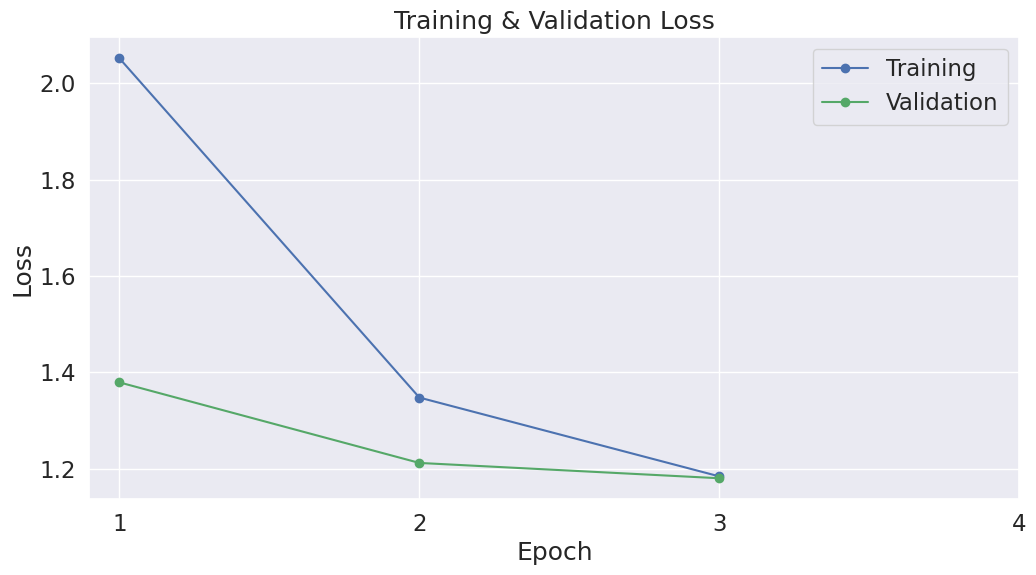

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


As the number of epochs increases, the loss of both training and validation sets are nearing equal. This shows that there is a chance that I am overfitting, or will soon be overfitting the data.

# Predictions

## ASAP Test Set

In [28]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [29]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [30]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader_test:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,298 test sentences...
    DONE.


In [31]:
print(f'length: {len(predictions)}')
print(f'shape of each array: {predictions[0].shape}')
predictions

length: 41
shape of each array: (32, 61)


[array([[ 0.13067432,  0.21308804, -0.19861464, ..., -0.39123747,
         -0.98729795, -1.1754087 ],
        [ 3.6506746 ,  6.4339623 ,  4.784791  , ..., -0.77961874,
         -0.9928903 , -1.0997341 ],
        [ 1.0337462 ,  4.2137895 ,  6.8236456 , ..., -0.8114283 ,
         -0.60460025, -0.72231954],
        ...,
        [ 0.6303399 ,  3.4061203 ,  6.5889006 , ..., -0.7454548 ,
         -0.7246402 , -0.650406  ],
        [-0.6311902 , -0.9996514 , -1.8439819 , ..., -0.28261343,
         -1.0717001 , -1.2466977 ],
        [-2.2661192 , -2.217605  , -1.3272189 , ..., -0.30673814,
         -0.09834789, -0.43286717]], dtype=float32),
 array([[-0.4978538 ,  1.0953586 ,  2.8651407 , ..., -0.37992254,
         -0.8728916 , -0.6170691 ],
        [-1.0884362 , -0.00543027,  1.3992913 , ..., -0.18669535,
         -0.57687753, -0.5804866 ],
        [-0.2684472 , -0.04343079, -0.18979907, ..., -1.3184919 ,
         -1.4788841 , -1.1672418 ],
        ...,
        [-0.60420066,  0.68433535,  2.2

In [32]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label with the highest score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [33]:
accuracy = accuracy_score(flat_true_labels, flat_predictions) # debug
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

0.5778120184899846
              precision    recall  f1-score   support

           0       0.82      0.43      0.56        42
           1       0.69      0.71      0.70       170
           2       0.63      0.72      0.68       245
           3       0.72      0.66      0.69       289
           4       0.65      0.70      0.67       139
           5       0.00      0.00      0.00        10
           6       0.67      0.43      0.52        14
           7       0.00      0.00      0.00        18
           8       0.53      0.84      0.65        82
           9       0.24      0.19      0.21        37
          10       0.47      0.52      0.49        42
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        12
          16       0.34      0.85      0.48        27
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


There is poor accuracy when we take a look at the test set: about 57.8%. The model is better at classifying the scores that are smaller than scores that are above 10. This is likely due to the imbalance in labels.

## ELLIPSE Test Set

In [34]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [35]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)

# Combine the results across all batches.
flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

# For each sample, pick the label with the highest score.
flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([10,  8, 10, 20,  8, 10, 10, 10,  2,  8,  8,  8, 10, 10, 40, 10, 10,
       20,  8, 10,  8, 10,  4,  9,  3,  3,  4, 10, 10,  8,  8, 10,  8, 10,
        8,  8, 10,  8,  8,  8, 40,  8,  8,  8,  4, 16, 40, 10,  2,  2,  8,
        6,  8,  8,  1,  8,  4, 10,  8, 16, 10,  8,  8, 10,  2,  6,  8,  8,
       20, 40,  3,  9,  4,  8,  2,  8, 10, 10, 10,  8,  8,  3,  8,  6,  3,
        8,  1, 20,  8,  8,  2,  8,  8,  6,  1,  2, 10, 10,  8,  8, 21, 10,
        8, 10,  8,  8,  8,  8,  2,  8,  2,  8, 10, 16,  8, 16,  2,  8,  8,
        8, 40,  8, 10, 10,  8,  8,  8,  6, 10, 10,  8,  8,  8,  6,  8, 10,
        1, 10,  8, 10, 10, 10,  4, 16,  8,  6,  6, 16,  8,  6,  6,  8,  2,
        8,  8, 10, 10, 10,  8, 40,  8, 16,  4,  8,  2, 10,  8, 10,  8,  2,
        3,  1,  3,  8,  3,  9, 10, 16,  8,  8, 10,  3,  2,  8,  8,  8,  8,
       10,  8,  8, 10,  8,  1, 10,  3,  4,  8,  1,  8,  8,  8,  8, 10, 10,
       10,  8,  8, 40, 10,  2,  6,  2,  4, 10,  8,  8,  8,  8,  8,  3,  2,
        8,  8,  8, 40,  1

Mimicking what will happen in the real world when the model is applied to new sets, I will not know how a human rater would rate these essays. I would only know these are the scores the model produced.

## ASAP and ELL Test Comparisons

Now, I compare the distributions of ASAP and ELL test sets scores. Are they different from each other?

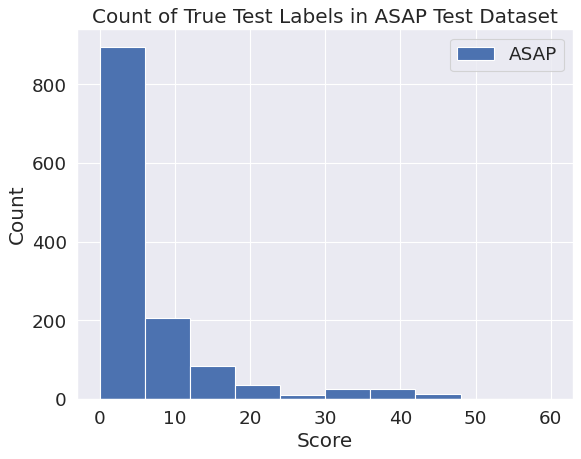

In [37]:
figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP')
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The distribution of the test labels mimic the distribution found in the training set with a right skew. There are few labels that are above a 10.

In [38]:
flat_predictions.shape

(1298,)

In [39]:
flat_predictions_ell.shape

(774,)

In [40]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

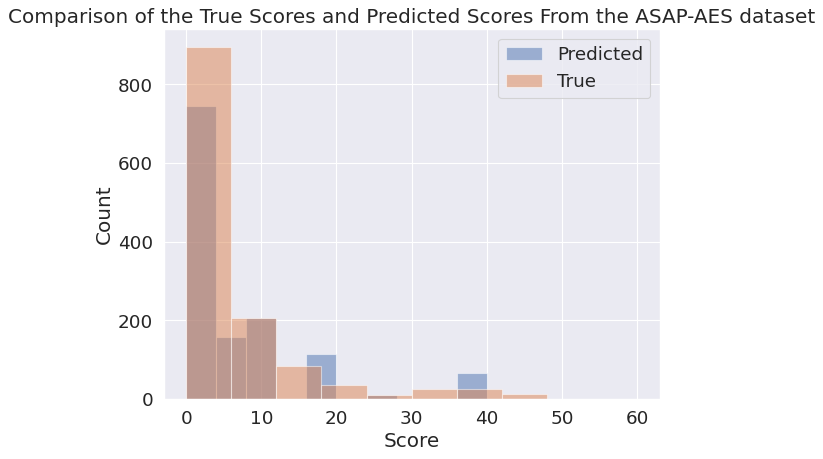

In [46]:
figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predicted')
plt.hist(flat_true_labels, alpha=0.5, label='True')
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

It would appear that the scores are predicted to be slightly higher than the actual scores. The distribution remains similar with a strong right skew.

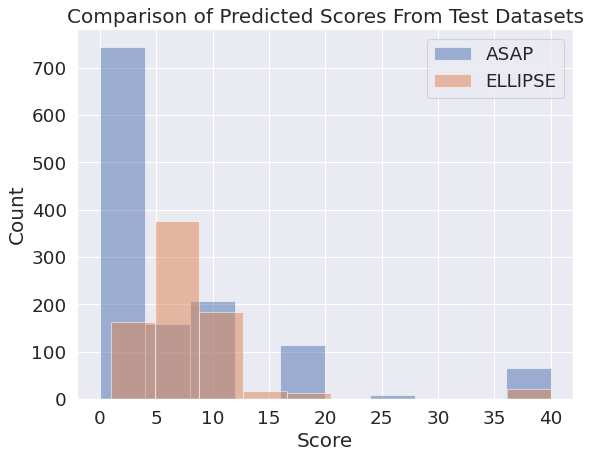

In [41]:
figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP')
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE')
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Intuition tells me that ELLs would not be as confident in their English essays because they are learning English. Their English is likely not to be as good as an English speaker who grew up speaking and writing in English. However, the scores for the ELL essays seem to be higher than those in the ASAP distribution.

This could be explained by the fact that the data isn't good. The true ASAP-AES labels are lower numbers in the first place. Maybe the ELLIPSE essays would score even higher if it wasn't working against the imbalance data.

In [42]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100

In [43]:
a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

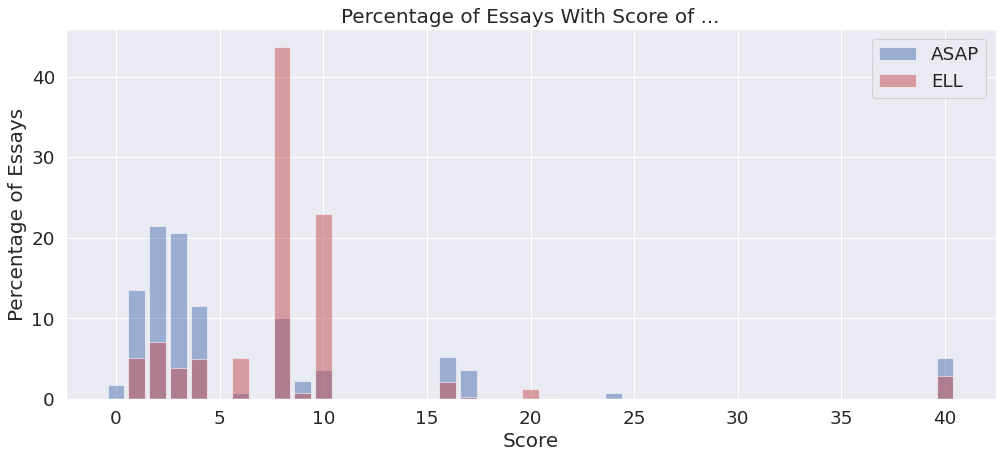

In [44]:
width = 0.8
figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELL')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

When I converted the counts to be percentages, I still see the same picture where the scores are predisposed to be lower numbers.

In [45]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -4.804714955043585
P-value: 1.6610004935324308e-06


There is a significant difference between the two populations, but the ELL students are receiving higher scores than the general population; however, it is unknown what caused the ELL scores to be higher scoring. Is it because there are more words? Is it because the essays have better grammar? It would be impossible to tell whether it is because they answered the prompt better or not.

# Conclusion

There are differences between the ASAP-AES essays and the ELL essays. They were written by different populations, have different word counts, and are on different topics. It is impossible to tell what specific factors would cause the difference in scores.

Furthermore, only about 57.8% of the essays have their scores being predicted correctly even when the essays are similar to the training data. I can try to increase the accuracy and make the model better, but the research hasn't progressed to that part yet.

I am using categorical cross entropy loss, but the ASAP-AES Kaggle competition used a quadratic kappa error calculation to determine how closely the predicted scores on the actual test are simlar to the human scores. The winner is about 81.7% similar (the quadratic kappa error ranges from 0 to 1 and measures how similar the two are). Thus the question becomes, **what is the threshold for accuracy/similarity?** If I am to sell an AES AI to a standardized testing company, would they accept it if I tell them they are about 80% similar to what a human would score them as? As a student, if I found out that the test which could potentially determine my future is graded by an AI that is only about 80% similar to a human scorer, would I be angry? The AI can't even explain to me why I received such a score.

**How data savvy would the people using the AI be?** Most companies would like to keep their training set as private because data is expensive. Would the people buying access to the AI know what the data is trained on and the distribution of their labels? Data imbalance can affect the distribution of predicted scores. The AI is also limited in what it can predict. For example, this AI will never be able to predict out of 100, so if a grader wants the output to be between 0 and 100, another model will have to be built, and will likely need another dataset.